Imports that are necessary for the engine to function correctly.

In [1]:
import os
import io
import random
import chess
import chess.pgn
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical
from tqdm import tqdm
from torch.amp import autocast, GradScaler
from sqlalchemy import create_engine, Column, Integer, Text
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy.orm import sessionmaker
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
torch.cuda.is_available()

Using device: cuda


True

Below cell is connecting to the database of elite chess games, making it possible to fetch data later on in the training process.

In [2]:
Base = declarative_base()

class ChessGame(Base):
    __tablename__ = 'games'
    id = Column(Integer, primary_key=True)
    pgn = Column(Text)

engine = create_engine('sqlite:///../chess_games.db')
Session = sessionmaker(bind=engine)
session = Session()

C:\Users\lukas\AppData\Local\Temp\ipykernel_17112\736078126.py:1: MovedIn20Warning: The ``declarative_base()`` function is now available as sqlalchemy.orm.declarative_base(). (deprecated since: 2.0) (Background on SQLAlchemy 2.0 at: https://sqlalche.me/e/b8d9)
  Base = declarative_base()


Opening book is a very useful tool when creating a Chess Engine because it makes it possible for the model to take part of large theory knowledge. Below are some functions to use an opening book in pgn format. Also searching in the opening book for matching moves in order to make it more dynamic. When choosing move, it might select a random move out of the matching openings in order to make the games less deterministic and more interesting.

In [3]:
def load_openings_from_pgn(pgn_file):
    openings = []
    with open(pgn_file) as f:
        while True:
            game = chess.pgn.read_game(f)
            if game is None:
                break

            board = game.board()
            moves = []
            for move in game.mainline_moves():
                moves.append(board.san(move))
                board.push(move)

            openings.append(moves)
    return openings

#Function to find matching openings based on played moves
def find_matching_openings(played_moves, openings):
    """
    Finding opening works by checking if the played moves match the start of any opening in the opening book.
    This is because a chosen opening can be diverged from at any point by the opponent.
    This makes the bot more dynamic in the opening phase.
    """
    matching_openings = []
    for opening in openings:
        if played_moves == opening[:len(played_moves)]:
            matching_openings.append(opening)
    return matching_openings

#Function to choose the next move from matching openings
def select_next_move(played_moves, matching_openings, rand = True):
    if not matching_openings:
        return None  # No matching opening found, time for engine

    
    if rand:
        chosen_opening = random.choice(matching_openings)

        if len(chosen_opening) > len(played_moves):
            next_move = chosen_opening[len(played_moves)]
            return next_move
    else:
        for opening in matching_openings:
            if len(opening) > len(played_moves):
                next_move = opening[len(played_moves)]
                return next_move
    return None  # No more moves in the opening book, time for engine

#Load the openings
openings = load_openings_from_pgn("eco.pgn")

#Example usage
played_moves = ["e4"]  
matching_openings = find_matching_openings(played_moves, openings)
next_move = select_next_move(played_moves, matching_openings)

if next_move:
    print(f"Bot's next move: {next_move}")
else:
    print("No matching opening found, calculate the move using engine logic.")

Bot's next move: c5


Model architecture is a CNN-Transformer. The CNN part is used to extract features from the board state and the Transformer part is used to make predictions based on the features extracted by the CNN. This is a powerful architecture when dealing with chess because it can learn to recognize patterns in the board state and make predictions based on those patterns.

In [4]:
class ChessNet(nn.Module):
    def __init__(self):
        super(ChessNet, self).__init__()

        self.conv1 = nn.Conv2d(13, 64, kernel_size=3, padding=1) # 13 channels for the 12 piece types and an extra channel for the color the bot is playing
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        
        self.bn1 = nn.BatchNorm2d(64)
        self.bn2 = nn.BatchNorm2d(128)
        self.bn3 = nn.BatchNorm2d(128)

        self.res_conv1 = nn.Conv2d(13, 64, kernel_size=1)  # To match channels for residual
        self.res_conv2 = nn.Conv2d(64, 128, kernel_size=1)  # To match channels for residual
        
        #Positional encoding for the transformer
        self.positional_encoding = PositionalEncoding(d_model=128)

        #Transformer Encoder
        encoder_layers = nn.TransformerEncoderLayer(d_model=128, nhead=16)
        self.transformer = nn.TransformerEncoder(encoder_layers, num_layers=3)

        self.layer_norm = nn.LayerNorm(128)

        #Fully connected layer
        self.fc1 = nn.Linear(8*8*128, 4096)  #4096 possible moves

    def forward(self, x):

        residual = self.res_conv1(x)
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = x + residual
       # x += F.interpolate(residual, size=x.shape[2:]) 

        residual = self.res_conv2(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = x + residual

        residual = x
        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = x + residual

        x = x.view(-1, 128, 8*8)  #[batch_size, d_model, sequence_length]
        x = x.permute(2, 0, 1)  #[sequence_length, batch_size, d_model]

        # Positional encoding
        x = self.positional_encoding(x)

        # Transformer encoder
        x = self.transformer(x)

        x = self.layer_norm(x)

        x = x.permute(1, 0, 2).contiguous()  #[batch_size, sequence_length, d_model]
        x = x.view(-1, 8*8*128)
        x = self.fc1(x)
        return x

#Positional encoding for the transformer in order to give the model information about the position of the pieces
#Uses the sine and cosine functions to encode the position of the board in a unique way
#Experimental, might be overkill. Saw somewhere it could be useful for the transformer, but not sure if it is properly implemented here
class PositionalEncoding(nn.Module): 
    def __init__(self, d_model, max_len=64):
        super(PositionalEncoding, self).__init__()
        self.encoding = torch.zeros(max_len, d_model)
        self.encoding.requires_grad = False

        pos = torch.arange(0, max_len).float().unsqueeze(1)
        _2i = torch.arange(0, d_model, 2).float()

        self.encoding[:, 0::2] = torch.sin(pos / (10000 ** (_2i / d_model)))
        self.encoding[:, 1::2] = torch.cos(pos / (10000 ** (_2i / d_model)))
        self.encoding = self.encoding.unsqueeze(1)

    def forward(self, x):
        return x + self.encoding[:x.size(0), :].to(x.device)

Old model that used 12 channels in the input convolutional layer instead of 13, because I was stupid and did not clarify for the engine which side it was playing. Code is still here for testing purposes.

In [5]:
class ChessNetOld(nn.Module):
    def __init__(self):
        super(ChessNetOld, self).__init__()

        self.conv1 = nn.Conv2d(13, 64, kernel_size=3, padding=1) # 13 channels for the 12 piece types and an extra channel for the color the bot is playing
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        
        self.bn1 = nn.BatchNorm2d(64)
        self.bn2 = nn.BatchNorm2d(128)
        self.bn3 = nn.BatchNorm2d(128)

        self.dropout = nn.Dropout(p=0.3)

        self.res_conv1 = nn.Conv2d(13, 64, kernel_size=1)  # To match channels for residual
        self.res_conv2 = nn.Conv2d(64, 128, kernel_size=1)  # To match channels for residual
        
        #Positional encoding for the transformer
        self.positional_encoding = PositionalEncoding(d_model=128)

        #Transformer Encoder
        encoder_layers = nn.TransformerEncoderLayer(d_model=128, nhead=8)
        self.transformer = nn.TransformerEncoder(encoder_layers, num_layers=2)

        #Fully connected layer
        self.fc1 = nn.Linear(8*8*128, 4096)  #4096 possible moves

    def forward(self, x):

        residual = self.res_conv1(x)
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x += F.interpolate(residual, size=x.shape[2:]) 

        residual = self.res_conv2(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.dropout(x)
        x += residual  

        residual = x
        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.dropout(x)
        x += residual

        x = x.view(-1, 128, 8*8)  #[batch_size, d_model, sequence_length]
        x = x.permute(2, 0, 1)  #[sequence_length, batch_size, d_model]

        # Positional encoding
        x = self.positional_encoding(x)

        # Transformer encoder
        x = self.transformer(x)

        x = x.permute(1, 0, 2).contiguous()  #[batch_size, sequence_length, d_model]
        x = x.view(-1, 8*8*128)
        x = self.fc1(x)
        return x

Training loop and some functions for training the model is coded below. Using cross entropy loss and Adam optimizer, the model becomes pretty good at predicting the elite player's move in a given board state. Moves are also skipped in the beginning of the games to not unfairly punish the model for not predicting the first moves correctly, since most opening moves are interchangeable.

In [6]:
def board_to_input(board, is_white):
    board_planes = np.zeros((8, 8, 13), dtype=np.float32)
    for square in chess.SQUARES:
        piece = board.piece_at(square)
        if piece:
            plane = piece.piece_type - 1
            if piece.color == chess.BLACK:
                plane += 6
            row, col = divmod(square, 8)
            board_planes[row, col, plane] = 1
    board_planes[:, :, 12] = 1.0 if is_white else 0.0
    return board_planes

#Encode the move TODO: Make it possible to encode promotion moves. ATM it only encodes the move from and to square and is unable to promote.
def move_to_output(move):
    from_square = move.from_square
    to_square = move.to_square
    return from_square * 64 + to_square

def calculate_accuracy(output, target):
    _, predicted = torch.max(output, 1)
    correct = (predicted == target).sum().item()
    return correct / target.size(0)

In [7]:
#Training step with move skipping and batching
def train_on_batch(games, model, optimizer, criterion, device, skip_moves=10):
    all_board_inputs = []
    all_targets = []
    total_moves = 0

    for game_str in games:
        pgn_io = io.StringIO(game_str)
        game = chess.pgn.read_game(pgn_io)
        board = game.board()
        move_count = 0

        for move in game.mainline_moves():
            #A static number of moves are skipped to avoid overfitting to the opening book
            #More sophisticated methods can be used to skip exact amount of book moves, but it is too inefficient for my machine
            if move_count < skip_moves:
                board.push(move)
                move_count += 1
                continue

            #Prepare the input and output
            is_white = board.turn == chess.WHITE
            board_input = board_to_input(board, is_white)
            board_input = torch.tensor(board_input, dtype=torch.float32).unsqueeze(0).permute(0, 3, 1, 2).to(device)
            actual_output = move_to_output(move)
            actual_output = torch.tensor([actual_output], dtype=torch.long).to(device)

            all_board_inputs.append(board_input)
            all_targets.append(actual_output)
            total_moves += 1

            #Update the board with the actual move
            board.push(move)

        del pgn_io, game, board, move

    if all_board_inputs:
        #Stack all inputs and targets
        batch_inputs = torch.cat(all_board_inputs, dim=0)
        batch_targets = torch.cat(all_targets, dim=0)

        del all_board_inputs, all_targets
        torch.cuda.empty_cache()

        optimizer.zero_grad()
        output = model(batch_inputs)

        loss = criterion(output, batch_targets)
        accuracy = calculate_accuracy(output, batch_targets)
        _, top3_pred = torch.topk(output, k=3, dim=1)  # Get the top-3 predictions
        correct_moves_in_top3 = (top3_pred == batch_targets.unsqueeze(1)).sum(dim=1).float()
        top3_accuracy = correct_moves_in_top3.mean().item()

        loss.backward()
        optimizer.step()

        del batch_inputs, batch_targets, output, top3_pred, correct_moves_in_top3, _
        torch.cuda.empty_cache()

        return loss.item(), accuracy, total_moves, top3_accuracy
    else:
        return 0, 0, 0  #If no valid moves in batch

#Training loop
batch_size = 1024
game_batch_size = 16 
offset = 0
step = 0
j = 0

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ChessNet().to(device)
model.load_state_dict(torch.load('savedModels/updated_again_model_current.pth')) #Load the model from the previous training session
model.train()
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

while True:
    games = session.query(ChessGame).offset(offset).limit(batch_size).all()
    if not games:
        break

    total_loss = 0.0
    total_accuracy = 0.0
    total_moves = 0
    total_top3_accuracy = 0.0
    

    with tqdm(total=len(games) // game_batch_size, desc=f"Processing Batch {offset // batch_size + 1}") as pbar:
        
        for i in range(0, len(games), game_batch_size):
            if offset // batch_size + 1 <2019:
                break
            game_batch = [game.pgn for game in games[i:i + game_batch_size]]
            loss, accuracy, moves, top3_accuracy = train_on_batch(game_batch, model, optimizer, criterion, device, skip_moves=10)
            total_loss += loss * moves
            total_accuracy += accuracy * moves
            total_top3_accuracy += top3_accuracy * moves
            total_moves += moves
            pbar.update(1)
            if total_moves > 0:
                pbar.set_postfix({'Loss': total_loss / total_moves, 'Accuracy': total_accuracy / total_moves, 'Top-3 Accuracy': total_top3_accuracy / total_moves})

            del game_batch, loss, accuracy, moves, top3_accuracy
            torch.cuda.empty_cache()
    
    j += 1
    offset += batch_size
    if offset // batch_size + 1 < 2019:
        continue
    if j % 25 == 0:
        model_save_path = os.path.join('savedModels', f'updated_again_model_{j}.pth')
        torch.save(model.state_dict(), model_save_path)
    model_save_path = os.path.join('savedModels', f'updated_again_model_current.pth')
    torch.save(model.state_dict(), model_save_path)
    
#Close the session and TensorBoard writer
#Still have not tried TensorBoard, might not work
session.close()
model_save_path = os.path.join('savedModels', f'updated_again_model_final.pth')
torch.save(model.state_dict(), model_save_path)
#1976

c:\Users\lukas\Chess_GitHub\ChessBot\.venv\Lib\site-packages\torch\nn\modules\transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
C:\Users\lukas\AppData\Local\Temp\ipykernel_17112\468113630.py:73: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no l

KeyboardInterrupt: 

In [ ]:
puzzles_df = pd.read_csv('../../Datasets/lichess_puzzle_transformed.csv')

print(puzzles_df.head())
len(puzzles_df)

In [ ]:
def train_on_puzzle_batch(puzzle_batch, model, optimizer, criterion, device):
    all_board_inputs = []
    all_targets = []
    total_moves = 0
    # Loop through the dataframe in batches
        

    for _, row in puzzle_batch.iterrows():
        # Extract FEN and move sequence
        fen = row[2]
        #print(fen)
        move_sequence = row[3].split()
        #print(move_sequence)
        # Initialize the board from the starting FEN
        board = chess.Board(fen)

        # Process the sequence of moves one by one
        for move in move_sequence:
            # Convert the board to the input tensor

            is_white = board.turn == chess.WHITE
            board_input = board_to_input(board, is_white)
            board_input = torch.tensor(board_input, dtype=torch.float32).unsqueeze(0).permute(0, 3, 1, 2).to(device)
            actual_output = move_to_output(chess.Move.from_uci(move))
            #print(actual_output)
            #print(move)
            actual_output = torch.tensor([actual_output], dtype=torch.long).to(device)

            all_board_inputs.append(board_input)
            all_targets.append(actual_output)
            total_moves += 1

            # Apply the correct move to the board, so the next input is the real next position
            board.push(chess.Move.from_uci(move))
    
    if all_board_inputs:
        # Stack inputs and targets into tensors
        batch_inputs = torch.cat(all_board_inputs, dim=0)
        batch_targets = torch.cat(all_targets, dim=0)

        optimizer.zero_grad()
        output = model(batch_inputs)

        loss = criterion(output, batch_targets)
        accuracy = calculate_accuracy(output, batch_targets)

        loss.backward()
        optimizer.step()

        # Calculate accuracy
        predicted_moves = torch.argmax(output, dim=1)
        accuracy = (predicted_moves == batch_targets).sum().item() / len(batch_targets)


        del batch_inputs, batch_targets, output
        torch.cuda.empty_cache()

        return loss.item(), accuracy, total_moves
    else:
        return 0, 0, 0  #If no valid moves in batch

batch_size = 4096
game_batch_size = 64
offset = 0
step = 0
j = 0

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ChessNet().to(device)
model.load_state_dict(torch.load('savedModels/puzzle_trained_current.pth')) #Load the model from the previous training session
model.train()
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

while True:
    #puzzles_df = pd.read_csv('../../Datasets/lichess_puzzle_transformed.csv')

    total_loss = 0.0
    total_accuracy = 0.0
    total_moves = 0
    
    with tqdm(total=batch_size // game_batch_size, desc=f"Processing Batch {offset // batch_size + 1}") as pbar:
        
        for i in range(0, batch_size, game_batch_size):
            if offset // batch_size + 1 <100:
                break
            # Get the batch of puzzles
            #i += offset
            puzzle_batch = puzzles_df.iloc[i+offset:i+offset+game_batch_size]
            #print(puzzle_batch.head())
            loss, accuracy, moves = train_on_puzzle_batch(puzzle_batch, model, optimizer, criterion, device)
            total_loss += loss * moves
            total_accuracy += accuracy * moves
            total_moves += moves
            pbar.update(1)
            if total_moves > 0:
                pbar.set_postfix({'Loss': total_loss / total_moves, 'Accuracy': total_accuracy / total_moves})

            del loss, accuracy, moves, puzzle_batch
            torch.cuda.empty_cache()

            if i > offset + batch_size:
                break
    
    j += 1
    if j % 25 == 0:
        model_save_path = os.path.join('savedModels', f'puzzle_trained_{j}.pth')
        torch.save(model.state_dict(), model_save_path)
    model_save_path = os.path.join('savedModels', f'puzzle_trained_current.pth')
    torch.save(model.state_dict(), model_save_path)
    offset += batch_size


RL part is not implemented yet, but below is an attempt to create one. I believe the idea and strategy can be correct if properly implemented, but as of right now it is not working as well as intended.

In [ ]:
###### RL PART ######

model = ChessNet().to(device)
model.load_state_dict(torch.load('savedModels/cnn_transformer_model_epoch_60.pth'))


def board_to_input(board):
    board_planes = torch.zeros((8, 8, 12), dtype=torch.float32)
    for square in chess.SQUARES:
        piece = board.piece_at(square)
        if piece:
            plane = piece.piece_type - 1
            if piece.color == chess.BLACK:
                plane += 6
            row, col = divmod(square, 8)
            board_planes[row, col, plane] = 1
    board_input = board_planes.unsqueeze(0).permute(0, 3, 1, 2)
    return board_input

def move_to_index(move):
    from_square = move.from_square
    to_square = move.to_square
    return from_square * 64 + to_square

# Function to select a move given the current board position. Not currently used in the training loop whilst trying to fix some stuff
def select_move(model, board):
    state = board_to_input(board)
    state = state.unsqueeze(0) 

    
    logits = model(state) 
    probabilities = torch.softmax(logits, dim=1)

    legal_moves = list(board.legal_moves)
    legal_indices = [move_to_index(move) for move in legal_moves]

    mask = torch.zeros_like(probabilities)
    mask[:, legal_indices] = 1  # Mask out illegal moves

    legal_probabilities = probabilities * mask  # Apply the mask
    legal_probabilities = legal_probabilities / legal_probabilities.sum(dim=1, keepdim=True)  # Re-normalize

    m = Categorical(legal_probabilities)
    # Sample from moves based on the distribution of probabilities.
    # In the early stages of training, the bot will explore many moves that it does not particularly prefer, 
    # but as the training progresses, the bot will start to get better, the distribution of probabilities of moves will more greatly favor the better moves, 
    # leading to less exploration.
    move_idx = m.sample() 

    selected_move = legal_moves[move_idx.item()]
    return selected_move, m.log_prob(move_idx)

# Function to simulate a batch of games of self-play
def play_batch_games(model, batch_size):
    boards = [chess.Board() for _ in range(batch_size)]
    log_probs = [[] for _ in range(batch_size)]
    rewards = [[] for _ in range(batch_size)]
    previous_material_balances = [material_balance(board) for board in boards]
    checkmate_count = 0
    while any(not board.is_game_over() for board in boards):
        active_indices = [i for i, board in enumerate(boards) if not board.is_game_over()]
        states = [board_to_input(boards[i]) for i in active_indices]
        states = torch.cat(states).to(device)

        
        logits = model(states) 
        probabilities = torch.softmax(logits, dim=1)

        for idx, i in enumerate(active_indices):
            legal_moves = list(boards[i].legal_moves)
            if len(legal_moves) == 0:
                continue  # Skip if no legal moves are available

            legal_indices = [move_to_index(move) for move in legal_moves]
            mask = torch.zeros_like(probabilities[idx])
            mask[legal_indices] = 1
            legal_probabilities = probabilities[idx] * mask

            if legal_probabilities.sum() == 0:
                print("All legal probabilities are zero")
                legal_probabilities = mask  # fallback to uniform distribution over legal moves

            legal_probabilities = legal_probabilities / legal_probabilities.sum(dim=0, keepdim=True)

            m = Categorical(legal_probabilities)
            move_idx = m.sample()

            log_prob = m.log_prob(move_idx) 
            log_probs[i].append(log_prob)

            move_idx_in_legal_moves = legal_indices.index(move_idx.item()) if move_idx.item() in legal_indices else None

            if move_idx_in_legal_moves is None:
                continue  # Safeguard against out-of-bound indices

            selected_move = legal_moves[move_idx_in_legal_moves]
            boards[i].push(selected_move)

            if boards[i].is_checkmate():
                checkmate_count += 1  # Increment checkmate counter
                #Greatly reward the bot for checkmating the opponent
                rewards[i].append(5)
                break

            # If too many moves, break
            if len(rewards[i]) > 200:
                boards[i].push(chess.Move.null())
                # Penalize the bot for taking too many moves
                rewards[i][-1] -= 0.5
                break

            current_material_balance = material_balance(boards[i])
            reward = current_material_balance - previous_material_balances[i]

            if boards[i].turn == chess.WHITE:  # Bot just played as black
                rewards[i].append(-reward)  # Negative reward if bot is black (after white's move)
            else:  # Bot just played as white
                rewards[i].append(reward)  # Positive reward if bot is white (after black's move)

            previous_material_balances[i] = current_material_balance

    for i in range(batch_size):
        result = boards[i].result()
        
        for j in range(len(rewards[i])):
            rewards[i][j] -= 0.01 # Penalize each move to try make the bot not do many unnecessary moves

        if result == '1-0':  # White wins
            if len(rewards[i]) % 2 == 1:  
                rewards[i][-1] += 1  
                rewards[i][-2] -= 1 

        elif result == '0-1':  # Black wins
            if len(rewards[i]) % 2 == 1:  
                rewards[i][-1] += 1  
                rewards[i][-2] -= 1  

        elif result == '1/2-1/2':  # Draw
            rewards[i][-1] += 0.5  
            if len(rewards[i]) > 1:
                rewards[i][-2] += 0.5  

    del states, logits, probabilities
    torch.cuda.empty_cache()

    return log_probs, rewards, checkmate_count



def material_balance(board):
    white_material = 0
    black_material = 0
    
    for square in chess.SQUARES:
        piece = board.piece_at(square)
        if piece is not None:
            value = piece_value(piece)
            if piece.color == chess.WHITE:
                white_material += value
            else:
                black_material += value

    return white_material - black_material  # Positive if white has more material

# Function to assign value to pieces TODO: fix right values since these are maybe not good
def piece_value(piece):
    if piece is None:
        return 0
    elif piece.piece_type == chess.PAWN:
        return 0.1
    elif piece.piece_type in [chess.KNIGHT, chess.BISHOP]:
        return 0.3
    elif piece.piece_type == chess.ROOK:
        return 0.5
    elif piece.piece_type == chess.QUEEN:
        return 0.9
    return 0

def update_policy_batch(log_probs_batch, rewards_batch, optimizer, gamma=0.99):
    policy_loss = 0

    for log_probs, rewards in zip(log_probs_batch, rewards_batch):
        R = 0
        returns = []
        for r in rewards[::-1]:
            R = r + gamma * R
            returns.insert(0, R)

        returns = torch.tensor(returns, dtype=torch.float32, requires_grad=False).to(device) # requires_grad=False since having problems with torch.no_grad during self-play. Trying to fix it
        returns = (returns - returns.mean()) / (returns.std() + 1e-5)  # Normalize returns

        for log_prob, R in zip(log_probs, returns):
            policy_loss += -log_prob * R

    return policy_loss

def train_self_play_batch(model, optimizer, num_episodes=1000, batch_size=4, accumulation_steps=4):
    model.train()
    scaler = GradScaler()  # Initialize the gradient scaler for mixed precision
    total_checkmates = 0
    optimizer.zero_grad() 

    for episode in tqdm(range(num_episodes), desc="Training Progress"):
        episode_loss = 0

        for _ in range(accumulation_steps):
            log_probs_batch, rewards_batch, checkmate_count = play_batch_games(model, batch_size)
            
            # Ensure autocast is used only during forward pass
            with autocast(device_type="cuda"):  # Enable mixed precision during policy update
                policy_loss = update_policy_batch(log_probs_batch, rewards_batch, optimizer)

                # Accumulate the loss
                episode_loss += policy_loss / accumulation_steps

        # Check that episode_loss requires gradients
       # assert episode_loss.requires_grad, "episode_loss does not require gradients."

        # Backward pass with scaled gradients after accumulation
        scaler.scale(episode_loss).backward()
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()

        total_checkmates += checkmate_count  #Count checkmates as metric for progress in early stages

        if episode % 10 == 0:
            avg_reward = sum(sum(rewards) for rewards in rewards_batch) / batch_size
            print(f"Episode {episode} complete - Average Reward: {avg_reward:.2f}, Checkmates: {total_checkmates / (episode + 1) * batch_size:.2f}%")
            total_checkmates = 0

        if episode % 100 == 0:
            model_save_path = os.path.join('savedModels', f'cnn_transformer_model_rl_{episode}.pth')
            torch.save(model.state_dict(), model_save_path)

optimizer = optim.Adam(model.parameters(), lr=0.001)

train_self_play_batch(model, optimizer, num_episodes=1000, batch_size=16, accumulation_steps=16)

Another attempt at RL below, skip.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ChessNet().to(device)
model.load_state_dict(torch.load('savedModels/cnn_transformer_model_current.pth'))

scaler = GradScaler()

# Functions to convert board states and moves
def board_to_input(board):
    board_planes = torch.zeros((8, 8, 12), dtype=torch.float32)
    for square in chess.SQUARES:
        piece = board.piece_at(square)
        if piece:
            plane = piece.piece_type - 1
            if piece.color == chess.BLACK:
                plane += 6
            row, col = divmod(square, 8)
            board_planes[row, col, plane] = 1
    board_input = board_planes.unsqueeze(0).permute(0, 3, 1, 2)
    return board_input.to(device)

def move_to_index(move):
    from_square = move.from_square
    to_square = move.to_square
    return from_square * 64 + to_square

def piece_value(piece):
    if piece is None:
        return 0
    elif piece.piece_type == chess.PAWN:
        return 1
    elif piece.piece_type in [chess.KNIGHT, chess.BISHOP]:
        return 3
    elif piece.piece_type == chess.ROOK:
        return 5
    elif piece.piece_type == chess.QUEEN:
        return 9
    return 0

def material_balance(board):
    white_material = 0
    black_material = 0
    
    for square in chess.SQUARES:
        piece = board.piece_at(square)
        if piece is not None:
            value = piece_value(piece)
            if piece.color == chess.WHITE:
                white_material += value
            else:
                black_material += value

    return white_material - black_material  # Positive if white has more material

def center_control(board):
    central_squares = [chess.D4, chess.E4, chess.D5, chess.E5]
    control_score = 0

    for square in central_squares:
        attackers = board.attackers(chess.WHITE, square)
        defenders = board.attackers(chess.BLACK, square)

        if len(attackers) > len(defenders):
            control_score += 0.1
        elif len(attackers) < len(defenders):
            control_score -= 0.1

    return control_score

def select_move(model, board):
    state = board_to_input(board)
    state = state.unsqueeze(0)  # Add batch dimension

    with torch.no_grad():
        logits = model(state)
    probabilities = torch.softmax(logits, dim=1)

    legal_moves = list(board.legal_moves)
    legal_indices = [move_to_index(move) for move in legal_moves]

    mask = torch.zeros_like(probabilities)
    mask[:, legal_indices] = 1  # Mask out illegal moves

    legal_probabilities = probabilities * mask  # Apply the mask
    legal_probabilities = legal_probabilities / legal_probabilities.sum(dim=1, keepdim=True)  # Re-normalize

    m = Categorical(legal_probabilities)
    move_idx = m.sample()

    selected_move = legal_moves[move_idx.item()]
    return selected_move, m.log_prob(move_idx)

def dynamic_gamma(move_count):
    if move_count < 20:
        return 0.95  # Early game
    elif move_count < 40:
        return 0.98  # Mid game
    else:
        return 0.99  # End game

def play_batch_games(model, batch_size):
    boards = [chess.Board() for _ in range(batch_size)]
    log_probs = [[] for _ in range(batch_size)]
    rewards = [[] for _ in range(batch_size)]
    previous_material_balances = [material_balance(board) for board in boards]
    checkmate_count = 0
    move_count = 0

    while any(not board.is_game_over() for board in boards):
        active_indices = [i for i, board in enumerate(boards) if not board.is_game_over()]
        states = torch.cat([board_to_input(boards[i]) for i in active_indices])

        logits = model(states)
        probabilities = torch.softmax(logits, dim=1)

        for idx, i in enumerate(active_indices):
            legal_moves = list(boards[i].legal_moves)
            if len(legal_moves) == 0:
                continue  # Skip if no legal moves are available

            legal_indices = [move_to_index(move) for move in legal_moves]
            mask = torch.zeros_like(probabilities[idx])
            mask[legal_indices] = 1
            legal_probabilities = probabilities[idx] * mask

            if legal_probabilities.sum() == 0:
                legal_probabilities = mask  # fallback to uniform distribution over legal moves

            legal_probabilities = legal_probabilities / legal_probabilities.sum(dim=0, keepdim=True)

            m = Categorical(legal_probabilities)
            move_idx = m.sample()

            log_prob = m.log_prob(move_idx)
            log_probs[i].append(log_prob)

            move_idx_in_legal_moves = legal_indices.index(move_idx.item()) if move_idx.item() in legal_indices else None

            if move_idx_in_legal_moves is None:
                continue  # Safeguard against out-of-bound indices

            selected_move = legal_moves[move_idx_in_legal_moves]
            boards[i].push(selected_move)

            if boards[i].is_checkmate():
                checkmate_count += 1  # Increment checkmate counter
                break

            current_material_balance = material_balance(boards[i])
            current_control_score = center_control(boards[i])
            reward = current_material_balance - previous_material_balances[i] + current_control_score

            if boards[i].turn == chess.WHITE:  # Bot just played as black
                rewards[i].append(-reward)  # Negative reward if bot is black (after white's move)
            else:  # Bot just played as white
                rewards[i].append(reward)  # Positive reward if bot is white (after black's move)

            previous_material_balances[i] = current_material_balance
            move_count += 1

    for i in range(batch_size):
        result = boards[i].result()

        for j in range(len(rewards[i])):
            rewards[i][j] -= 0.01  # Penalize each move to try make the bot not do many unnecessary moves

        if result == '1-0':  # White wins
            if len(rewards[i]) % 2 == 1:
                rewards[i][-1] += 1
                rewards[i][-2] -= 1

        elif result == '0-1':  # Black wins
            if len(rewards[i]) % 2 == 1:
                rewards[i][-1] += 1
                rewards[i][-2] -= 1

        elif result == '1/2-1/2':  # Draw
            rewards[i][-1] += 0.5
            if len(rewards[i]) > 1:
                rewards[i][-2] += 0.5

    return log_probs, rewards, checkmate_count, move_count

def update_policy_batch(log_probs_batch, rewards_batch, optimizer, move_count):
    optimizer.zero_grad()
    gamma = dynamic_gamma(move_count)

    for log_probs, rewards in zip(log_probs_batch, rewards_batch):
        R = 0
        returns = []
        for r in rewards[::-1]:
            R = r + gamma * R
            returns.insert(0, R)

        returns = torch.tensor(returns).to(device)
        returns = (returns - returns.mean()) / (returns.std() + 1e-5)  # Normalize returns

        for log_prob, R in zip(log_probs, returns):
            loss = -log_prob * R
            scaler.scale(loss).backward(retain_graph=True)

    scaler.step(optimizer)
    scaler.update()

def train_self_play_batch(model, optimizer, num_episodes=1000, batch_size=8, accumulate_grad_steps=4):
    model.train()
    total_checkmates = 0

    for episode in tqdm(range(num_episodes), desc="Training Progress"):
        log_probs_batch, rewards_batch, checkmate_count, move_count = play_batch_games(model, batch_size)
        update_policy_batch(log_probs_batch, rewards_batch, optimizer, move_count)

        total_checkmates += checkmate_count  # Count checkmates as metric for progress in early stages

        if episode % 10 == 0:
            avg_reward = sum(sum(rewards) for rewards in rewards_batch) / batch_size
            print(f"Episode {episode} complete - Average Reward: {avg_reward:.2f}, Checkmates: {total_checkmates/(episode+1)*batch_size:.2f}%")
            total_checkmates = 0

        if episode % 100 == 0:
            model_save_path = os.path.join('savedModels', f'cnn_transformer_model_rl_{episode}.pth')
            torch.save(model.state_dict(), model_save_path)
            

# Initialize optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Start training
train_self_play_batch(model, optimizer, num_episodes=1000, batch_size=8, accumulate_grad_steps=4)

Below you can play against the engine. It is painstakingly annoying to play, since there is no real UI and you have to input the moves in uci format. Will fix integration with the chess game and UI soon.

c:\Users\lukas\Chess_GitHub\ChessBot\.venv\Lib\site-packages\torch\nn\modules\transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
C:\Users\lukas\AppData\Local\Temp\ipykernel_17112\1508652110.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no l

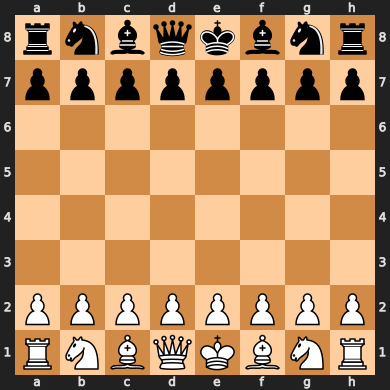

a


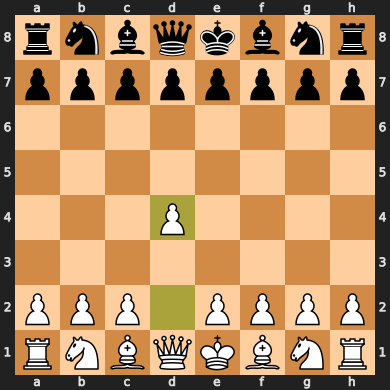

a


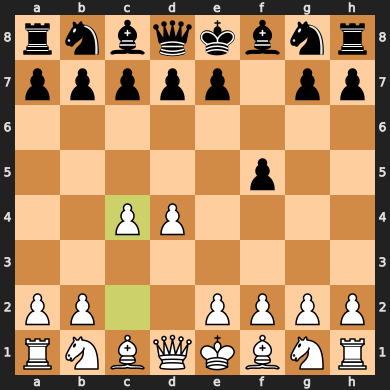

a


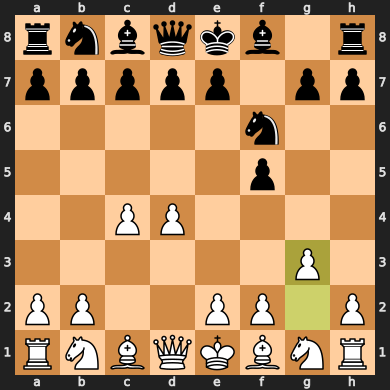

RuntimeError: Given groups=1, weight of size [64, 13, 1, 1], expected input[1, 8, 8, 13] to have 13 channels, but got 8 channels instead

In [16]:
model = ChessNet()
model.load_state_dict(torch.load('savedModels/updated_again_model_current.pth'))
model.eval()

board = chess.Board()

def board_to_input(board):
    board_planes = torch.zeros((8, 8, 13), dtype=torch.float32)
    for square in chess.SQUARES:
        piece = board.piece_at(square)
        if piece:
            plane = piece.piece_type - 1
            if piece.color == chess.BLACK:
                plane += 6
            row, col = divmod(square, 8)
            board_planes[row, col, plane] = 1
    
    is_white = board.turn == chess.WHITE
    board_planes[:, :, 12] = 1.0 if is_white else 0.0
    
    board_input = board_planes.unsqueeze(0)#.permute(0, 3, 1, 2) 
    return board_input

def predict_move(model, board):
    board_input = board_to_input(board)
    with torch.no_grad():
        output = model(board_input)
    
    move_scores = output.squeeze().sort(descending=True)
    move_indices = move_scores.indices.tolist()
    
    for move_index in move_indices:
        from_square = move_index // 64
        to_square = move_index % 64
        move = chess.Move(from_square, to_square)
        #if pawn and last character is 1 or eight, add 'q' to the move
        #Hopefully this works, always promotes to queen
        if board.piece_at(from_square).piece_type == 1 and (str(move)[-1] == '1' or str(move)[-1] == '8'):
            move = chess.Move(from_square, to_square, promotion=5) 
        print(move, move_scores.values[move_index].item())
        
        if move in board.legal_moves:
            return move
    
    # If no valid moves are found (which shouldn't happen), return None
    return None

played_moves = []
opening_phase = True
player_white = False
first_move_done = False
while not board.is_game_over():
    display(board)  
    

    if player_white or first_move_done:
        user_move = input("Your move: ")
        try:
            move = chess.Move.from_uci(user_move)
            if move in board.legal_moves:
                played_moves.append(board.san(move))
                board.push(move)
            else:
                print("Invalid move. Try again.")
                continue
        except ValueError:
            print("Invalid format. Use UCI format (e.g., e2e4).")
            continue

    if board.is_game_over():
        break
    #Get the bots move
    if opening_phase:
        matching_openings = find_matching_openings(played_moves, openings)
        next_move = select_next_move(played_moves, matching_openings)
    if opening_phase and next_move:
        print("a")
        played_moves.append(next_move)
        move = board.parse_san(next_move)
        board.push(move)
    else:
        bot_move = predict_move(model, board)
        opening_phase = False
        if bot_move:
            board.push(bot_move)
        else:
            print("Bot could not find a valid move.")
            break
    first_move_done = True

print("Game over!")
print(f"Result: {board.result()}")


In [12]:
model = ChessNet().to(device)
model.load_state_dict(torch.load('savedModels/updated_again_model_1625.pth'))
model.eval()

modelOld = ChessNet().to(device)
modelOld.load_state_dict(torch.load('savedModels/updated_again_model_current.pth'))

#modelOld = ChessNetOld().to(device)
#modelOld.load_state_dict(torch.load('savedModels/updated_model_2000.pth'))
modelOld.eval()

def save_game_to_pgn(board, result, filename="games.pgn"):
    game = chess.pgn.Game.from_board(board)
    game.headers["Result"] = result
    with open(filename, "a") as f:
        f.write(str(game) + "\n\n")

def board_to_input(board, param):
    board_planes = torch.zeros((8, 8, param), dtype=torch.float32)
    for square in chess.SQUARES:
        piece = board.piece_at(square)
        if piece:
            plane = piece.piece_type - 1
            if piece.color == chess.BLACK:
                plane += 6
            row, col = divmod(square, 8)
            board_planes[row, col, plane] = 1
    
    if param == 13:
        is_white = board.turn == chess.WHITE
        board_planes[:, :, 12] = 1.0 if is_white else 0.0
    
    board_input = board_planes.unsqueeze(0).permute(0, 3, 1, 2) 

    return board_input

def predict_moves_batch(model, boards, param):
    board_inputs = torch.cat([board_to_input(board, param) for board in boards]).to(device)
    with torch.no_grad():
        outputs = model(board_inputs)
    
    moves = []
    for output, board in zip(outputs, boards):
        move_scores = output.squeeze().sort(descending=True)
        move_indices = move_scores.indices.tolist()

        for move_index in move_indices:
            from_square = move_index // 64
            to_square = move_index % 64
            move = chess.Move(from_square, to_square)
            if board.piece_at(from_square) and board.piece_at(from_square).piece_type == chess.PAWN and (str(move)[-1] == '1' or str(move)[-1] == '8'):
                move = chess.Move(from_square, to_square, promotion=chess.QUEEN)

            if move in board.legal_moves:
                moves.append(move)
                break
        else:
            moves.append(None)  # No valid move found
    return moves

def play_games_in_batch(model_white, model_black, batch_size, new_num_layers, pgn_filename="games.pgn"):
    boards = [chess.Board() for _ in range(batch_size)]
    active = [True] * batch_size
    results = []
    played_moves_list = [[] for _ in range(batch_size)]  # Track the played moves for each game

    while any(active):
        # White's moves
        white_moves = []
        for i in range(batch_size):
            if active[i]:
                matching_openings = find_matching_openings(played_moves_list[i], openings)
                next_move = select_next_move(played_moves_list[i], matching_openings)
                print(next_move)
                if next_move:
                    print(boards[i])
                    print(next_move)
                    print(i)
                
                    move = boards[i].parse_san(next_move)
                    print(move)
                    
                    white_moves.append(move)
                else:
                    white_moves.append(predict_moves_batch(model_white, [boards[i]], 13)[0])
            else:
                white_moves.append(None)

        for i, move in enumerate(white_moves):
            if active[i]:
                if move:
                    print(i)
                    print(boards[i])
                    print(move)
                    
                    played_moves_list[i].append(boards[i].san(move))
                    boards[i].push(move) 
                
                if boards[i].is_checkmate(): 
                    result = "1-0" 
                    active[i] = False
                    results.append(result)
                    save_game_to_pgn(boards[i], result, pgn_filename)
                elif boards[i].is_game_over():
                    result = "1/2-1/2"
                    print(result)
                    active[i] = False
                    results.append(result)
                    save_game_to_pgn(boards[i], result, pgn_filename)
        print("b")
        # Black's moves
        if any(active):
            black_moves = []
            for i in range(batch_size):
                if active[i]:
                    matching_openings = find_matching_openings(played_moves_list[i], openings)
                    next_move = select_next_move(played_moves_list[i], matching_openings)
                    if next_move:
                        print(boards[i])
                        print(next_move)
                        move = boards[i].parse_san(next_move)
                        black_moves.append(move)
                        print(move)
                    else:
                        #print(i)
                        black_moves.append(predict_moves_batch(model_black, [boards[i]], 13)[0])
                else:
                    black_moves.append(None)

            for i, move in enumerate(black_moves):
                if active[i]:
                    if move:
                        played_moves_list[i].append(boards[i].san(move))
                        boards[i].push(move)
                        
                    if boards[i].is_checkmate(): 
                        result = "0-1" 
                        active[i] = False
                        results.append(result)
                        save_game_to_pgn(boards[i], result, pgn_filename)

                    elif boards[i].is_game_over():
                        result = "1/2-1/2"
                        print(result)
                        active[i] = False
                        results.append(result)
                        save_game_to_pgn(boards[i], result, pgn_filename)

    return results

# Run the batch of games
total_games = 320
batch_size = 32 
results = {'new_model_wins': 0, 'old_model_wins': 0, 'draws': 0}

# First 500 games: new model as White, old model as Black
for i in range(0, total_games//2, batch_size):
    batch_results = play_games_in_batch(model, modelOld, min(batch_size, 500 - i), True)
    
    for result in batch_results:
        if result == '1-0':
            results['new_model_wins'] += 1
        elif result == '0-1':
            results['old_model_wins'] += 1
        else:
            results['draws'] += 1

# Second 500 games: old model as White, new model as Black
for i in range(0, total_games//2, batch_size):
    batch_results = play_games_in_batch(modelOld, model, min(batch_size, 500 - i), True)
    
    for result in batch_results:
        if result == '1-0':
            results['old_model_wins'] += 1
        elif result == '0-1':
            results['new_model_wins'] += 1
        else:
            results['draws'] += 1

print("Simulation complete!")
print(f"New Model Wins: {results['new_model_wins']}")
print(f"Old Model Wins: {results['old_model_wins']}")
print(f"Draws: {results['draws']}")

C:\Users\lukas\AppData\Local\Temp\ipykernel_17112\394269623.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('savedModels/updated_again_m

d4
r n b q k b n r
p p p p p p p p
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
P P P P P P P P
R N B Q K B N R
d4
0
d2d4
d4
r n b q k b n r
p p p p p p p p
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
P P P P P P P P
R N B Q K B N R
d4
1
d2d4
e4
r n b q k b n r
p p p p p p p p
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
P P P P P P P P
R N B Q K B N R
e4
2
e2e4
e4
r n b q k b n r
p p p p p p p p
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
P P P P P P P P
R N B Q K B N R
e4
3
e2e4
e4
r n b q k b n r
p p p p p p p p
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
P P P P P P P P
R N B Q K B N R
e4
4
e2e4
e4
r n b q k b n r
p p p p p p p p
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
P P P P P P P P
R N B Q K B N R
e4
5
e2e4
d4
r n b q k b n r
p p p p p p p p
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
P P P P P P P P
R N B Q K B N R
d4
6
d2d4
e4
r n b q k 

In [16]:
state_dict = torch.load('savedModels/updated_model_2000.pth')

# Print the keys (layer names) in the state_dict
print("Model layers and parameters in the .pth file:")
for key in state_dict.keys():
    print(key)

# Optionally, print the shapes of the weights for each layer
print("\nLayer names and weight shapes:")
for key, value in state_dict.items():
    print(f"{key}: {value.shape}")

Model layers and parameters in the .pth file:
conv1.weight
conv1.bias
conv2.weight
conv2.bias
conv3.weight
conv3.bias
bn1.weight
bn1.bias
bn1.running_mean
bn1.running_var
bn1.num_batches_tracked
bn2.weight
bn2.bias
bn2.running_mean
bn2.running_var
bn2.num_batches_tracked
bn3.weight
bn3.bias
bn3.running_mean
bn3.running_var
bn3.num_batches_tracked
res_conv1.weight
res_conv1.bias
res_conv2.weight
res_conv2.bias
transformer.layers.0.self_attn.in_proj_weight
transformer.layers.0.self_attn.in_proj_bias
transformer.layers.0.self_attn.out_proj.weight
transformer.layers.0.self_attn.out_proj.bias
transformer.layers.0.linear1.weight
transformer.layers.0.linear1.bias
transformer.layers.0.linear2.weight
transformer.layers.0.linear2.bias
transformer.layers.0.norm1.weight
transformer.layers.0.norm1.bias
transformer.layers.0.norm2.weight
transformer.layers.0.norm2.bias
transformer.layers.1.self_attn.in_proj_weight
transformer.layers.1.self_attn.in_proj_bias
transformer.layers.1.self_attn.out_proj.wei

C:\Users\lukas\AppData\Local\Temp\ipykernel_18192\3995296126.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load('savedModels/updated_model_2000.pth'